# Making Art with EPA SWMM

After a hard day of H&H modeling, some of us may need to express ourselve with the other side of our brain. Let's play around with a model and make some useless but interesting visualizations. We'll need a few hidden features in swmmio: the {py:func}`swmmio.utils.functions.rotate_model` and {py:func}`swmmio.utils.spatial.centroid_and_bbox_from_coords` functions.

We'll start with the `jersey` example model. 

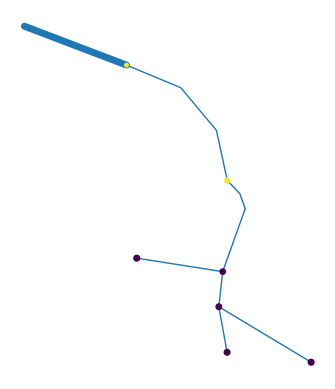

In [12]:
import numpy as np

import swmmio
from swmmio.examples import jersey
from swmmio.utils.functions import rotate_model
from swmmio.utils.spatial import centroid_and_bbox_from_coords

ax = jersey.links.geodataframe.plot(linewidth=jersey.links.dataframe['Geom1'], capstyle='round')
jersey.nodes.geodataframe.plot('MaxDepth', ax=ax, markersize='InvertElev', zorder=2)

# hide the axes since we're making art
ax.set_axis_off()

## But what if it was a Spirograph?
What happens if we spin the model around a bunch and replot it on the same figure? Would it be cool?

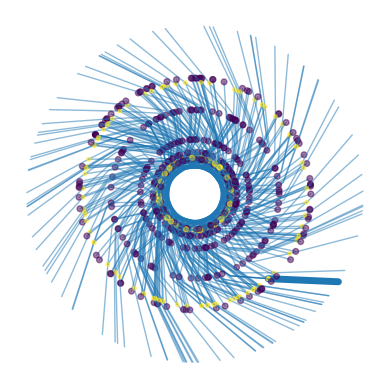

In [22]:
# first we'll get the centroid and the bounding box of the model 
# this is useful for rotating the model about its centroid
(xc, yc), [x1, y1, x2, y2] = centroid_and_bbox_from_coords(jersey.inp.coordinates)

# start the plot as usual
ax = jersey.links.geodataframe.plot(linewidth=jersey.links.dataframe['Geom1'], capstyle='round')
jersey.nodes.geodataframe.plot('MaxDepth', ax=ax, markersize='InvertElev', zorder=2)

# spin that thing around
for rads in np.arange(0, 3*3.14, 0.1):
    jersey = rotate_model(jersey,rads=rads, origin=(xc, yc))
    jersey.links.geodataframe.plot(linewidth=1, capstyle='round', ax=ax, alpha=0.5)
    jersey.nodes.geodataframe.plot('MaxDepth', ax=ax, markersize='InvertElev', zorder=2, alpha=0.5)

ax.set_axis_off()

Pretty cool. But what if we wasted more compute by making a 5x more stamps of the model. And what if we slide the model to the right after each iteration?

In [ ]:
# refresh the model 
jersey = swmmio.Model(jersey.inp.path)

# start the plot as usual
ax = jersey.links.geodataframe.plot(linewidth=jersey.links.dataframe['Geom1'], capstyle='round')
# jersey.nodes.geodataframe.plot('MaxDepth', ax=ax, markersize='InvertElev', zorder=2)

# spin that thing around
for rads in np.arange(0, 6*3.14, 0.05):
    jersey = rotate_model(jersey,rads=rads, origin=(xc+rads*50, yc))
    jersey.links.geodataframe.plot(linewidth=jersey.links.dataframe['Geom1'], capstyle='round', ax=ax, alpha=0.1)

ax.set_axis_off()

Now we are talking. 